# FOX Supervised Learning #

Using my hand-coded data set, in this notebook, I find the most effective machine learning models for classification.

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

In [2]:
fox_df = pd.read_excel('../data/interim/fox_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
fox_df.head()

,identifier,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,isad,contributor,...,has_next_back,has_prev_ahead,has_next_good evening,has_next_welcome,has_prev_after this,has_next_good morning,has_prev_applause,has_next_applause,has_prev_tuned,has_prev_go away
0,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,harris: it hasn't been a busy hour.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
1,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,glad you are long.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
2,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,got to see air force one with the president co...,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
3,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,keep watching fox news. here is dana.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
4,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,dana: your daily briefing starts now.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = np.array(fox_df['isad'])
X = fox_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['they dont want to',
 'and as i said ive put on as a lawyer expert witnesses',
 'bidens website has been updated with citations',
 'all that continues next',
 ' to build on what john said yes pomp circumstance and some politics which donald trump talked about on his trip']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [8]:
X_train_bow = vect.fit_transform(corpus_train)

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [9]:
X_test_bow = vect.transform(corpus_test)

In [10]:
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())

In [11]:
X_train_joined = X_train.reset_index().join(X_train_bow_df).drop(columns=['index'])

In [12]:
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_joined = X_test.reset_index().join(X_test_bow_df).drop(columns=['index'])

In [13]:
X_train_joined = X_train_joined.drop(columns=['sentence'])
X_test_joined = X_test_joined.drop(columns=['sentence'])

In [14]:
log = LogisticRegression(max_iter=10000)
log.fit(X_train_joined, y_train)
log_score = log.score(X_test_joined, y_test)
print('Logistic Regression Score: {}'.format(log_score))

Logistic Regression Score: 0.867


[[2515   18]
 [ 381   86]]


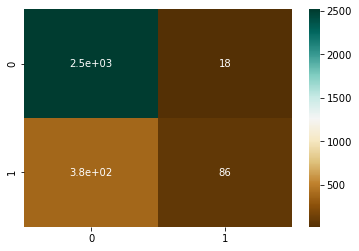

In [15]:
pred = log.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [16]:
rmse_val = []

for K in range(10):
    K = K+1
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    model.fit(X_train_joined, y_train)  #fit the model
    pred=model.predict(X_test_joined) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.3877284272958759
RMSE value for k=  2 is: 0.3894440481849308
RMSE value for k=  3 is: 0.3842742076521226
RMSE value for k=  4 is: 0.3665151201974256
RMSE value for k=  5 is: 0.3696845502136472
RMSE value for k=  6 is: 0.3444802848737017
RMSE value for k=  7 is: 0.3559026084010437
RMSE value for k=  8 is: 0.3459287017098562
RMSE value for k=  9 is: 0.35496478698597694
RMSE value for k=  10 is: 0.35260932110954374


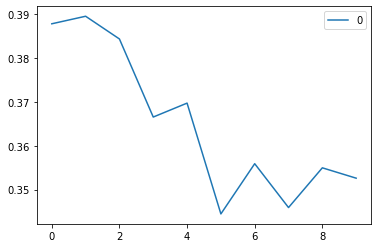

In [17]:
#elbow curve 
curve = pd.DataFrame(rmse_val) 
curve.plot()

In [18]:
model = neighbors.KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_joined, y_train)
model.score(X_test_joined, y_test)

0.8633333333333333

[[2355  178]
 [ 232  235]]


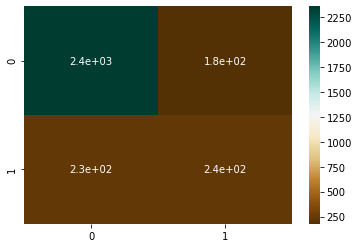

In [19]:
pred = model.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [20]:
svc = SVC()
svc.fit(X_train_joined, y_train)
score = svc.score(X_test_joined, y_test)
print('SVC Score is: {}'.format(score))

SVC Score is: 0.8443333333333334


[[2533    0]
 [ 467    0]]


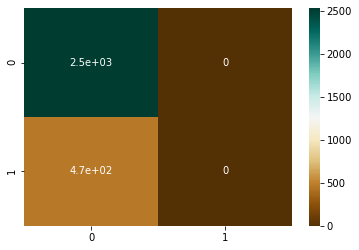

In [21]:
pred = svc.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [22]:
lsvc = LinearSVC(max_iter=100000)

In [23]:
lsvc.fit(X_train_joined, y_train)
score = lsvc.score(X_test_joined, y_test)
print('Linear SVC Score is: {}'.format(score))

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Linear SVC Score is: 0.8646666666666667


[[2527    6]
 [ 400   67]]


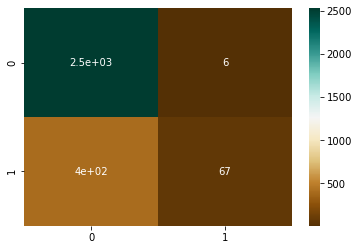

In [24]:
pred = lsvc.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [25]:
sgdc = SGDClassifier(loss='log', penalty='l1')
sgdc.fit(X_train_joined, y_train)
score = sgdc.score(X_test_joined, y_test)
print('SGDC score is: {}'.format(score))

SGDC score is: 0.8423333333333334


In [26]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

[[2527    6]
 [ 467    0]]


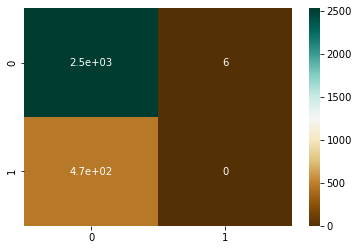

In [27]:
plot_confusion_matrix(sgdc, X_test_joined, y_test)

In [28]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train_joined, y_train)
score = dtc.score(X_test_joined, y_test)
print('DTC score is: {}'.format(score))

DTC score is: 0.874


[[2363  170]
 [ 208  259]]


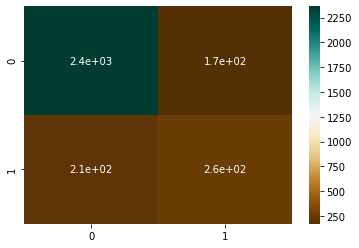

In [29]:
plot_confusion_matrix(dtc, X_test_joined, y_test)

In [30]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_joined, y_train)
score = rfc.score(X_test_joined, y_test)
print('RFC score is: {}'.format(score))

RFC score is: 0.8913333333333333


[[2459   74]
 [ 252  215]]


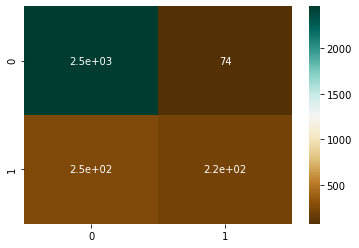

In [31]:
plot_confusion_matrix(rfc, X_test_joined, y_test)

In [32]:
bc = ensemble.BaggingClassifier()
bc.fit(X_train_joined, y_train)
score = bc.score(X_test_joined, y_test)
print('bc score is: {}'.format(score))

bc score is: 0.899


[[2445   88]
 [ 215  252]]


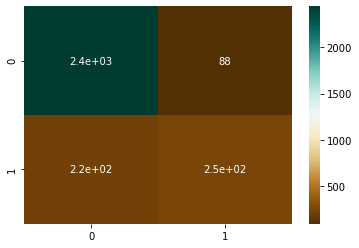

In [33]:
plot_confusion_matrix(bc, X_test_joined, y_test)

In [34]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train_joined, y_train)
score = gbc.score(X_test_joined, y_test)
print('gbc score is: {}'.format(score))

gbc score is: 0.8796666666666667


[[2523   10]
 [ 351  116]]


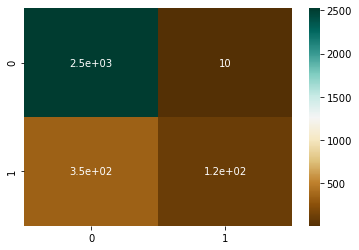

In [35]:
plot_confusion_matrix(gbc, X_test_joined, y_test)

In [36]:
abc = ensemble.AdaBoostClassifier()
abc.fit(X_train_joined, y_train)
score = abc.score(X_test_joined, y_test)
print('abc score is: {}'.format(score))

abc score is: 0.8776666666666667


[[2493   40]
 [ 327  140]]


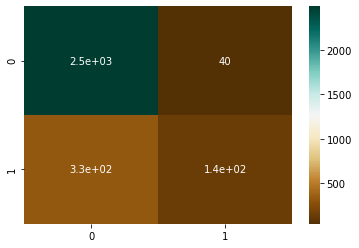

In [37]:
plot_confusion_matrix(abc, X_test_joined, y_test)